<a href="https://colab.research.google.com/github/LyaRB/SenalesySistemas/blob/main/cuaderno%205/Transformada_Z_Filtros_Digitales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descargue 10 segundos de la canción de su preferencia desde youtube, y generé un filtro pasabanda (el usuario debe poder definir las frecuencias de corte) para cada uno de los filtros descritos (el usuario también debe poder fijar los parámetros de diseño de cada filtro). Compare los resultados de los filtros estudiados en este cuaderno tipo IIR para diseño Butterworth, Chebyshev 1, Chebyshev 2, Bessel y Elíptico.

In [1]:
#librerias
!python3 -m pip install --force-reinstall https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz
!pip install soundfile
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf
import pandas as pd
import matplotlib as mpl
import yt_dlp as youtube_dl
import subprocess
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 8.0 MB/s eta 0:00:00
  Created w

In [2]:
#descargar el video de YouTube

def download_ytvid_as_mp3(video_url,name):
    video_info = youtube_dl.YoutubeDL().extract_info(url = video_url,download=False)
    filename = f"{name}.mp3"
    options={
        'format':'bestaudio/best',
        'keepvideo':False,
        'outtmpl':filename,
    }

    with youtube_dl.YoutubeDL(options) as ydl:
        ydl.download([video_info['webpage_url']])

    print("Download complete... {}".format(filename))


In [3]:
CAC = input("Ingrese el link de su cancion favorita: ")
download_ytvid_as_mp3(CAC,'Cancion')

subprocess.call(['ffmpeg','-y', '-i', 'Cancion'+'.mp3',
                   'Cancion'+'.wav'])

plc = np.array([33])    # El punto de lectura de la canción ingresada será en 25 segundos
tm = 10    #segundos de muestra
fs = 48000    #frecuencia de muestreo de un video en youtube
t = np.arange(0,5,1/fs)   #vector de tiempo
XC = np.zeros((1, int(tm * fs), 2))

x, fs = sf.read('/content/Cancion.wav')
for i,ti in enumerate(plc):
  XC[i] = x[int(fs*ti):int(fs*(ti+tm)),:] #aquí se crea la muestra de 10s de la cancion ingresada

XC_1 = XC[0,:,0]

Ingrese el link de su cancion favorita: https://www.youtube.com/watch?v=8n4S1-ctsZw
[youtube] Extracting URL: https://www.youtube.com/watch?v=8n4S1-ctsZw
[youtube] 8n4S1-ctsZw: Downloading webpage
[youtube] 8n4S1-ctsZw: Downloading ios player API JSON
[youtube] 8n4S1-ctsZw: Downloading android player API JSON
[youtube] 8n4S1-ctsZw: Downloading m3u8 information
[youtube] Extracting URL: https://www.youtube.com/watch?v=8n4S1-ctsZw
[youtube] 8n4S1-ctsZw: Downloading webpage
[youtube] 8n4S1-ctsZw: Downloading ios player API JSON
[youtube] 8n4S1-ctsZw: Downloading android player API JSON
[youtube] 8n4S1-ctsZw: Downloading m3u8 information
[info] 8n4S1-ctsZw: Downloading 1 format(s): 251
[download] Destination: Cancion.mp3
[download] 100% of    2.38MiB in 00:00:00 at 6.87MiB/s   
Download complete... Cancion.mp3


In [4]:
Audio(XC_1.T,rate=fs) #Audio original

Filtrado de la señal

Filtro Butterworth

In [5]:
from scipy.signal import butter as bw
from scipy.signal import freqz_zpk
from scipy.signal import lfilter,filtfilt

In [6]:
def plot_freq_response(filter, w, h, Orden): #Mostrar la respuesta en frecuencia del filtro
  fig = plt.figure()
  ax1 = fig.add_subplot(1, 1, 1)
  ax1.set_title(filter +' Digital filter frequency response, order= ' + str(Orden))
  ax1.plot(w, 20 * np.log10(abs(h)), 'b')
  ax1.set_ylabel('Amplitude [dB]', color='b')
  ax1.set_xlabel('Frequency [Hz]')
  ax1.grid()
  ax2 = ax1.twinx()
  angles = np.unwrap(np.angle(h))
  ax2.plot(w, angles, 'g')
  ax2.set_ylabel('Angle [radians]', color='g')
  plt.axis('tight')
  plt.show()

out = 'ba'

Ingrese el orden del circuito: 2
Ingrese la primera frecuencia de corte: 5000
Ingrese la segunda frecuencia de corte: 10000


<ipython-input-6-0bd7d1262fff>:5: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w, 20 * np.log10(abs(h)), 'b')


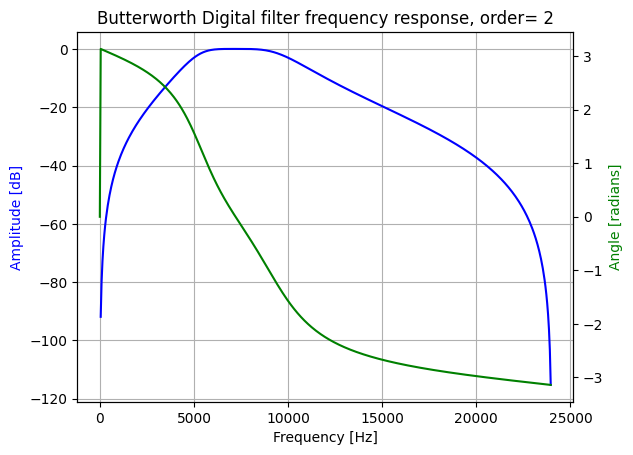

In [7]:
Orden = int(input("Ingrese el orden del circuito: ")) #orden el filtro
Fc1 = int(input("Ingrese la primera frecuencia de corte: ")) #frecuencias de corte
Fc2 = int(input("Ingrese la segunda frecuencia de corte: "))
Wn = [Fc1, Fc2] #banda pasante
filter = 'bandpass' #tipo del filtro
out = 'zpk'
zeros, poles, gain = bw(Orden , Wn, btype=filter, output=out, fs=fs)
w, h = freqz_zpk(zeros, poles, gain, fs=fs)
XF = filtfilt(zeros,poles, XC_1)
plot_freq_response('Butterworth', w, h, Orden)

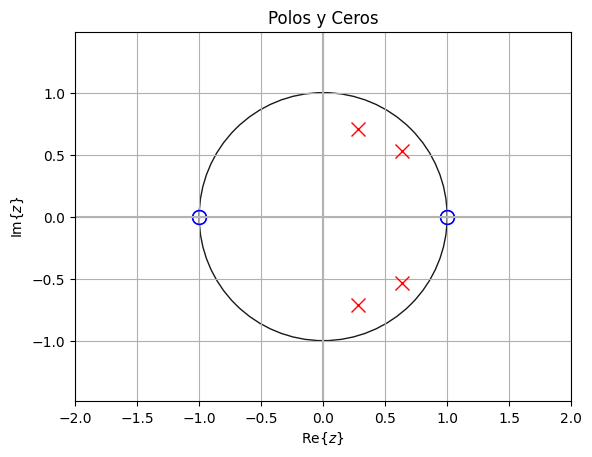

In [8]:
def show_zp(z, p, title= 'Z-plane'): # Mostrar la ubicación de los polos y los zeros
  ax = plt.gca()

  ax.plot(np.real(z), np.imag(z), 'bo', fillstyle='none', ms = 10)
  ax.plot(np.real(p), np.imag(p), 'rx', fillstyle='none', ms = 10)
  unit_circle = Circle((0,0), radius=1, fill=False,
                        color='black', ls='solid', alpha=0.9)
  ax.add_patch(unit_circle)
  ax.axvline(0, color='0.7')
  ax.axhline(0, color='0.7')

  plt.title(title)
  plt.xlabel(r'Re{$z$}')
  plt.ylabel(r'Im{$z$}')
  plt.axis('equal')
  plt.xlim((-2, 2))
  plt.ylim((-2, 2))
  plt.grid()

show_zp(zeros, poles, title='Polos y Ceros')

In [9]:
Audio(XF, rate = fs)

/usr/local/lib/python3.10/dist-packages/IPython/lib/display.py:159: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


Filtro Chevyshev 1

In [10]:
from scipy.signal import cheby1

In [11]:
Orden= int(input("Ingrese el orden del filtro"))
Ripple = int(input("Ingrese el rizado de la señal"))
Fc1 = int(input("Ingrese la primera frecuencia de corte"))
Fc2 = int(input("Ingrese la segunda frecuencia de corte"))
Wn = [Fc1,Fc2]
zeros, poles, gain = cheby1(Orden, rp=Ripple, Wn=Wn, btype=filter, output=out, fs=fs)
w, h = freqz_zpk(zeros, poles, gain, fs=fs)
XF = filtfilt(zeros,poles,XC_1)

Ingrese el orden del filtro4
Ingrese el rizado de la señal6
Ingrese la primera frecuencia de corte5000
Ingrese la segunda frecuencia de corte10000


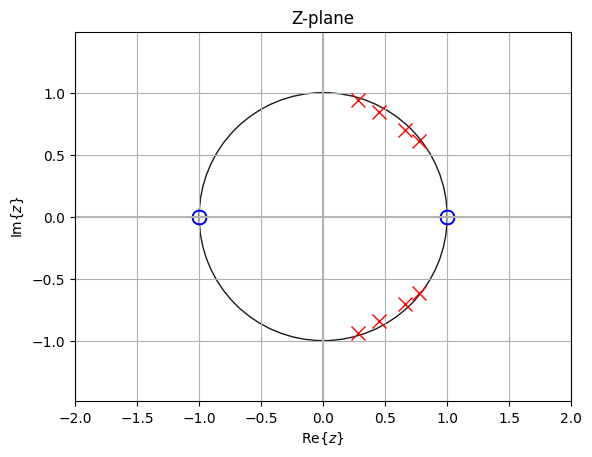

In [12]:
show_zp(zeros, poles)

<ipython-input-6-0bd7d1262fff>:5: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w, 20 * np.log10(abs(h)), 'b')


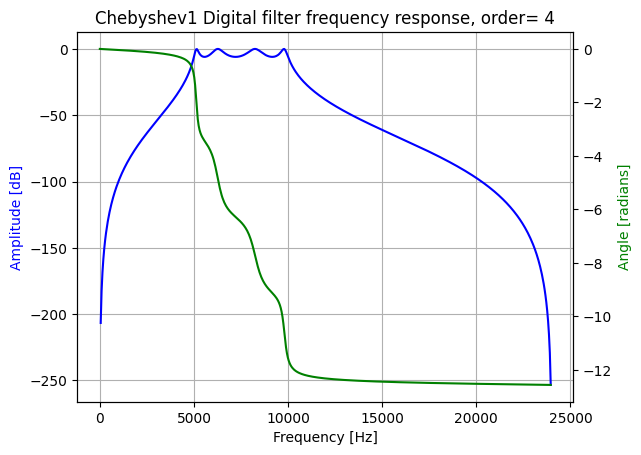

In [13]:
plot_freq_response('Chebyshev1', w, h, Orden)

In [14]:
Audio(XF, rate=fs)

Filtro Chevyshev 2

In [15]:
from scipy.signal import cheby2
from scipy.signal import freqz

In [19]:
Orden = int(input("Ingrese el orden del filtro: "))
Ripple = int(input("Ingrese el rizado: "))
Fc1 = int(input("Ingrese la primera de frecuencia de corte: "))
Fc2 = int(input("Ingrese la segunda frecuencia de corte: "))
Wn = [Fc1, Fc2]
out = 'ba' #no regresa los polos y ceros, sino la funcion de transferencia
num, den = cheby2(Orden, rs=Ripple, Wn=Wn, btype=filter, output=out, fs=fs) #regresa numerador y denominador. Si se quiere obtener los polos y ceros usar scipy.signal.tf2zpk
w, h = freqz(num, den, fs=fs)

Ingrese el orden del filtro: 4
Ingrese el rizado: 8
Ingrese la primera de frecuencia de corte: 5000
Ingrese la segunda frecuencia de corte: 10000


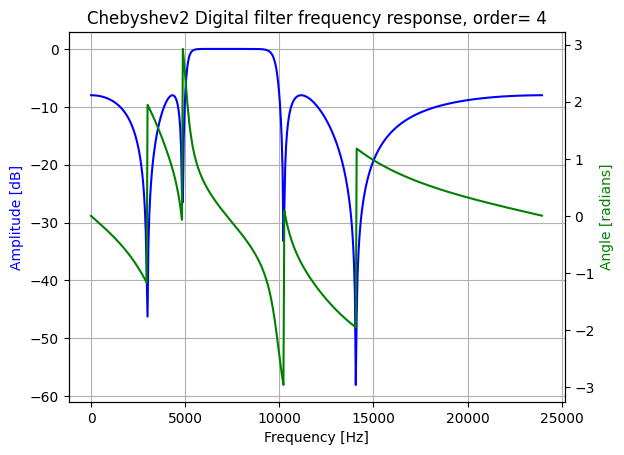

In [17]:
plot_freq_response('Chebyshev2', w, h, Orden)


Filtro Elíptico

In [20]:
from scipy.signal import ellip

In [21]:
Orden = int(input("Ingrese el orden del filtro: "))
Ripple = int(input("Ingrese el rizado: "))
Fc1 = int(input("Ingrese la primera de frecuencia de corte: "))
Fc2 = int(input("Ingrese la segunda frecuencia de corte: "))
Rp = int(input("Ingrese el risado de la banda pasante: "))
Rr = int(input("Ingrese el risado de la banda rechazada: "))
Wn = [Fc1, Fc2]
out = 'ba' #no regresa los polos y ceros, sino la funcion de transferencia
num, den = ellip(Orden, rp=Rp, rs=Rr, Wn=Wn, btype=filter, output=out, fs=fs) #regresa numerador y denominador. Si se quiere obtener los polos y ceros usar scipy.signal.tf2zpk
w, h = freqz(num, den, fs=fs)

Ingrese el orden del filtro: 4
Ingrese el rizado: 9
Ingrese la primera de frecuencia de corte: 5000
Ingrese la segunda frecuencia de corte: 10000
Ingrese el risado de la banda pasante: 2
Ingrese el risado de la banda rechazada: 30


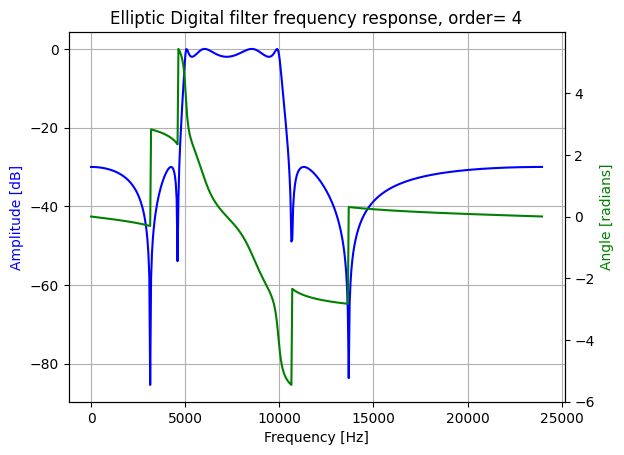

In [22]:
plot_freq_response('Elliptic', w, h, Orden)

Filtro de Bessel

In [23]:
from scipy.signal import bessel

In [24]:
Orden = int(input("Ingrese el orden del filtro: "))
normalizacion = 'mag' #ajusta la frecuencia
Fc1 = int(input("Ingrese la primera de frecuencia de corte: "))
Fc2 = int(input("Ingrese la segunda frecuencia de corte: "))
Wn = [Fc1, Fc2]
out = 'ba' #no regresa los polos y ceros, sino la funcion de transferencia
num, den = bessel(Orden, Wn=Wn, btype=filter, output=out, fs=fs) #regresa numerador y denominador. Si se quiere obtener los polos y ceros usar scipy.signal.tf2zpk
w, h = freqz(num, den, fs=fs)

Ingrese el orden del filtro: 4
Ingrese la primera de frecuencia de corte: 5000
Ingrese la segunda frecuencia de corte: 10000


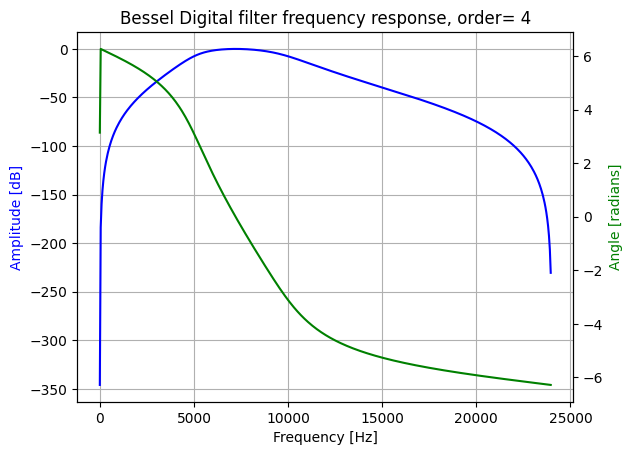

In [25]:
plot_freq_response('Bessel', w, h, Orden)

Consulte en qué consiste el método de diseño de filtros FIR por ventaneo (Ver función firwin y material de apoyo). Realice un cuadro comparativo de las ventajas y desventajas de los filtros IIR y los FIR. Nota: Recuerde que un filtro FIR utiliza solamente raíces tipo ceros, es decir que a0 = 1 , y ak = 0 para k={1,2,...}.

El método de diseño de filtros FIR (Finite Impulse Response) por ventaneo es una técnica utilizada para diseñar filtros digitales. Este método implica multiplicar la respuesta al impulso ideal (que es infinita en duración) por una ventana finita. Esto tiene el efecto de truncar la respuesta al impulso y, por lo tanto, limitar su duración finita. La elección de la ventana afecta las propiedades del filtro resultante, como la resolución en frecuencia y la atenuación del filtro.

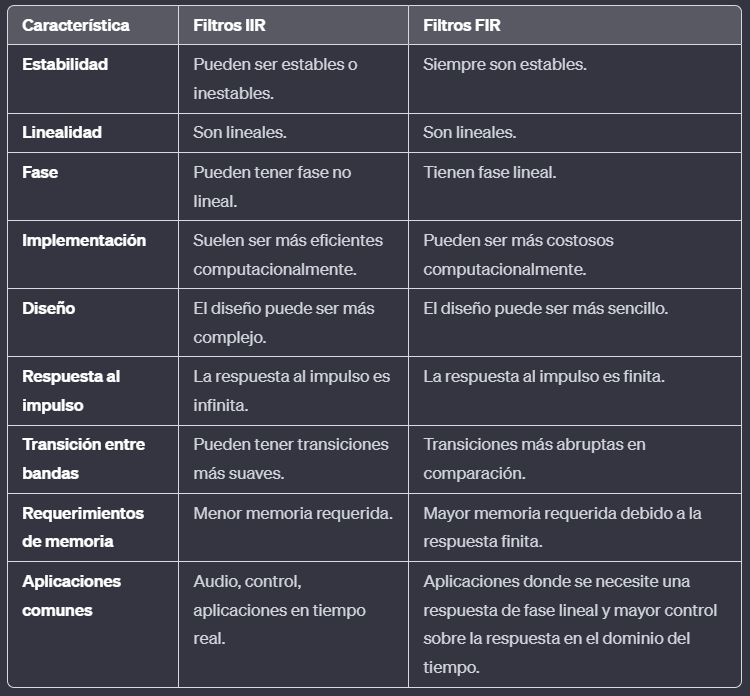

Incluya la implementación del filtro firwin en el punto 1.

In [26]:
#Diseño del filtro con firwin
from scipy import signal

In [30]:
Orden = int(input("Ingrese el orden del filtro: "))
Fc1 = int(input("Ingrese la primera frecuencia de corte:"))
Fc2 = int(input("Ingrese la segunda frecuencia de corte:"))
#Normalizaciòn datos ingresados
Fc1 /= fs/2.0
Fc2 /= fs/2.0
filtro = signal.firwin(Orden, [Fc1, Fc2], pass_zero=False) #El filtro FIR no cuenta con polos
w, h = signal.freqz(filtro, worN=8000)

Ingrese el orden del filtro: 4
Ingrese la primera frecuencia de corte:5000
Ingrese la segunda frecuencia de corte:10000


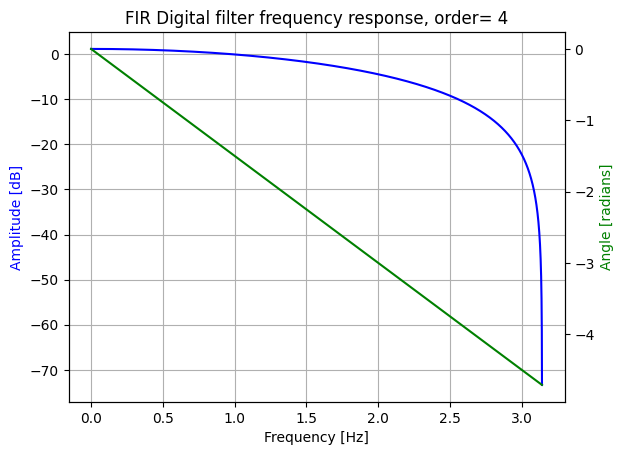

In [31]:
plot_freq_response('FIR', w, h, Orden)